# 1. Grab data

In [1]:
import numpy as np
import pandas as pd
import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import glob
import os

C:\Users\huang\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [ ]:
## Sử dụng GPU
import tensorflow as tf
from keras.backend import tensorflow_backend
config = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
session = tf.Session(config=config)
tensorflow_backend.set_session(session)

In [2]:
training_fruit_img = []
training_label = []
for dir_path in glob.glob("fruits-360/Training/*"):
    img_label = dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)
        image = cv2.resize(image, (64, 64))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        training_fruit_img.append(image)
        training_label.append(img_label)
training_fruit_img = np.array(training_fruit_img)
training_label = np.array(training_label)

In [3]:
label_to_id = {v:k for k,v in enumerate(np.unique(training_label)) }
id_to_label = {v:k for k,v in label_to_id.items() }

In [4]:
pd.DataFrame(id_to_label,index=['image Label'])

,0,1,2,3,4,5,6,7,8,9,...,61,62,63,64,65,66,67,68,69,70
image Label,Apple Braeburn,Apple Golden 1,Apple Golden 2,Apple Golden 3,Apple Granny Smith,Apple Red 1,Apple Red 2,Apple Red 3,Apple Red Delicious,Apple Red Yellow,...,Plum,Pomegranate,Quince,Rambutan,Raspberry,Salak,Strawberry,Strawberry Wedge,Tamarillo,Tangelo


In [5]:
training_label_id = np.array([label_to_id[i] for i in training_label])
training_label_id

array([ 0,  0,  0, ..., 70, 70, 70])

In [6]:
training_fruit_img.shape,training_label_id.shape

((35625, 64, 64, 3), (35625,))

In [7]:
validation_fruit_img=[]
validation_label =[]
for dir_path in glob.glob("fruits-360/Test/*"):
    img_label = dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)
        image = cv2.resize(image, (64, 64))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        validation_fruit_img.append(image)
        validation_label.append(img_label)
validation_fruit_img = np.array(validation_fruit_img)
validation_label = np.array(validation_label)

In [8]:
validation_label_id = np.array([label_to_id[i] for i in validation_label])
validation_label_id

array([ 0,  0,  0, ..., 70, 70, 70])

In [9]:
validation_fruit_img.shape,validation_label_id.shape

((11968, 64, 64, 3), (11968,))

In [10]:
X_train,X_test = training_fruit_img,validation_fruit_img
Y_train_r,Y_test_r =training_label_id,validation_label_id
#mean(X) = np.mean(X_train)
X_train = X_train/255
X_test = X_test/255

X_flat_train = X_train.reshape(X_train.shape[0],64*64*3)
X_flat_test = X_test.reshape(X_test.shape[0],64*64*3)

#One Hot Encode the Output
from keras.utils import to_categorical
num_of_classes = 71
Y_train = to_categorical(Y_train_r, num_of_classes)
Y_test = to_categorical(Y_test_r, num_of_classes)

# from keras.utils import to_categorical
# to_categorical(Y_test, 65)

# y_train = pd.get_dummies(Y_train)
# y_test = pd.get_dummies(Y_test)

print('Original Sizes:')
print('   - X_train:', X_train.shape)
print('   - X_test: ', X_test.shape)
print('   - Y_train:', Y_train.shape)
print('   - Y_test: ', Y_test.shape)

# print('Flattened:')
# print('   - X_flat_train:', X_flat_train.shape)
# print('   - X_flat_test: ', X_flat_test.shape)

Original Sizes:
   - X_train: (35625, 64, 64, 3)
   - X_test:  (11968, 64, 64, 3)
   - Y_train: (35625, 71)
   - Y_test:  (11968, 71)


(64, 64, 3)


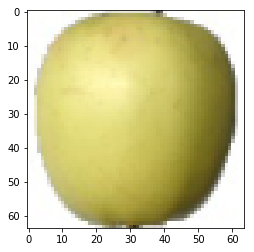

In [11]:
print(X_train[1200].shape)
plt.imshow(X_train[1200])
plt.show()

# 2. Create, compile & train model

In [12]:
# Create model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.layers import Activation, BatchNormalization, regularizers

model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=(64,64,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(16, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3 )))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())

# Fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(71))

model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 60, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 60, 60, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
__________

In [13]:
# compile model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# model.fit(X_train,
#           Y_train,
#           batch_size=128,
#           epochs=10,
#           verbose=1,
#           validation_data = (X_test,Y_test)
#          )

train_model_1 = model.fit(X_train, Y_train, 
                          batch_size=64, epochs=10, 
                          verbose=1, validation_data=(X_test, Y_test))

Train on 35625 samples, validate on 11968 samples
Epoch 1/10
35625/35625 [==============================] - 742s 21ms/step - loss: 0.2644 - acc: 0.9323 - val_loss: 0.3647 - val_acc: 0.8925
Epoch 2/10
35625/35625 [==============================] - 744s 21ms/step - loss: 0.0416 - acc: 0.9871 - val_loss: 0.6869 - val_acc: 0.8194
Epoch 3/10
35625/35625 [==============================] - 744s 21ms/step - loss: 0.0311 - acc: 0.9894 - val_loss: 0.1711 - val_acc: 0.9525
Epoch 4/10
35625/35625 [==============================] - 739s 21ms/step - loss: 0.0243 - acc: 0.9904 - val_loss: 1.6235 - val_acc: 0.7086
Epoch 5/10
35625/35625 [==============================] - 738s 21ms/step - loss: 0.0231 - acc: 0.9910 - val_loss: 0.2121 - val_acc: 0.9531
Epoch 6/10
35625/35625 [==============================] - 739s 21ms/step - loss: 0.0203 - acc: 0.9919 - val_loss: 0.3713 - val_acc: 0.8989
Epoch 7/10
35625/35625 [==============================] - 739s 21ms/step - loss: 0.0204 - acc: 0.9913 - val_loss: 0.

In [15]:
pd.DataFrame(train_model_1.history)

,acc,loss,val_acc,val_loss
0,0.932323,0.264421,0.892547,0.364719
1,0.987144,0.041636,0.819352,0.686910
2,0.989361,0.031056,0.952540,0.171096
3,0.990400,0.024348,0.708556,1.623462
4,0.991018,0.023054,0.953125,0.212099
5,0.991944,0.020286,0.898897,0.371286
6,0.991270,0.020370,0.940090,0.229697
7,0.992758,0.017344,0.923045,0.363703
8,0.991775,0.019104,0.958890,0.190359
9,0.992421,0.017401,0.909843,0.397469


In [16]:
from keras.models import save_model
save_model(model, 'HP.HDF5')

# 3.Classification report

In [17]:
from sklearn.metrics import classification_report
Y_pred = model.predict_classes(X_test)

print(classification_report(np.argmax(Y_test,axis=1),Y_pred,target_names=id_to_label.values()))

                     precision    recall  f1-score   support

     Apple Braeburn       0.57      0.86      0.69       164
     Apple Golden 1       0.73      0.99      0.84       164
     Apple Golden 2       1.00      0.16      0.27       164
     Apple Golden 3       0.65      1.00      0.79       161
 Apple Granny Smith       1.00      0.73      0.84       164
        Apple Red 1       1.00      0.43      0.60       164
        Apple Red 2       0.96      0.64      0.77       164
        Apple Red 3       1.00      0.83      0.91       144
Apple Red Delicious       1.00      0.95      0.98       166
   Apple Red Yellow       0.82      1.00      0.90       164
            Apricot       0.98      1.00      0.99       164
            Avocado       1.00      0.97      0.98       143
       Avocado ripe       0.95      1.00      0.98       166
             Banana       1.00      1.00      1.00       166
         Banana Red       1.00      0.93      0.96       166
       Cactus fruit    

# 4. Prediction using random banana pictures

In [18]:
def predict_img(path):
    img_label = path.split("\\")[-1]
    image = cv2.imread(path,cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    plt.imshow(image)
    plt.show()
    image = cv2.resize(image, (64, 64))
    image = image/255
    image = image.reshape(1,64,64,3)
    pred = model.predict_classes(image)
    print(id_to_label[pred[0]])    

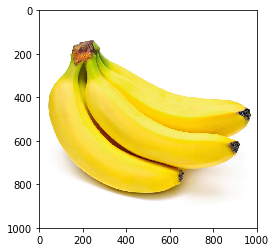

Carambula


In [19]:
path = r"E:\CBD\16.Fruit-classification-using-CNN\fruits-360\To_predict\4_bananas.jpg"
predict_img(path)

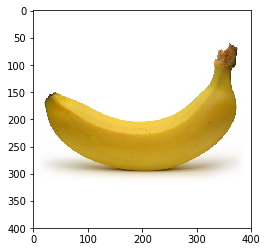

Banana


In [20]:
path = r"E:\CBD\16.Fruit-classification-using-CNN\fruits-360\To_predict\a_banana.jpg"
predict_img(path)

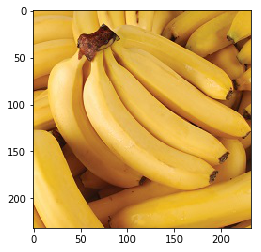

Carambula


In [21]:
path = r"E:\CBD\16.Fruit-classification-using-CNN\fruits-360\To_predict\many_bananas.jpg"
predict_img(path)